# Quasar light curve as a stochastic process (Damped Random Walk)
Using the Kelly et al. 2009 article *Are the variations in quasar optical flux driven by thermal fluctuations?* as a basis.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_theme()

Below, I've simply used equation (1) from Kelly et al. (2009):
$\begin{equation}
    dX(t) = -\frac{1}{\tau}X(t)dt + \sigma\sqrt{dt}\:\epsilon(t) + b\: dt
\end{equation}$
Where $\tau$ is the relaxation time or characteristic time, $\sigma$ is the variance, $\epsilon$ is a random white-noise process, described as gaussian with a mean of 0 and variance of 1, so I've chosen to use `np.random.normal(0, 1)` in its stead, and $b$ is the mean of the random walk, the value it should move towards as $t\rightarrow\infty$.

In [3]:
# defining the step dX(t):
def drw_step(t, tau, sigma, b, x0=0.):
    """Damped Random Walk Step

    Args:
        t (array): the time series
        tau (float): relaxation time / characteristic time scale, origin in characteristic timescales for quasars
        sigma (float): variance
        b (float): mean? unsure atm
        x0 (float): starting value
    
    Returns:
        x (array): Damped Random Walk
    """
    
    x = np.zeros_like(t) # make an array of length len(t)
    x[0] = x0
    dt = np.diff(t)
    
    # version 1: is not affected siginificantly by tau
    # for i in range(1, len(t)):
    #     x[i] = - tau**-1 * x[i-1] + sigma*np.sqrt(dt[i-1]) * np.random.normal(0, 1) + b*dt[i-1]
    
    # version 2: I had forgotten the dt in the first term - this overflows rapidly
    # for i in range(1, len(t)):
    #     x[i] = (-x[i-1]/tau) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal(0, 1) + b * dt[i-1]
    
    # version 3: adding exponential terms all over to make it less prone to overflow
    for i in range(1, len(t)):
        exp_term = np.exp(-dt[i-1] / tau)
        x[i] = x[i-1] * exp_term + sigma * np.sqrt(dt[i-1]) * np.random.normal(0, 1) + b * (1 - exp_term)
    
    return x

In version 3 the equation has been altered to the following:
$\begin{equation}
    dX(t) = X(t)\exp{\left[{-\frac{1}{\tau}dt}\right]} + \sigma\sqrt{dt}\:\epsilon(t) + b\: \left(1-\exp{\left[{-\frac{1}{\tau}dt}\right]}\right)
\end{equation}$

An alternative variance could be adding the expoential term as something like: $\sigma\sqrt{1-\exp{\left[{-\frac{1}{\tau}dt}\right]}}\:\epsilon(t)$, or $\sigma\sqrt{\tau\left(1-\exp{\left[{-\frac{1}{\tau}dt}\right]}\right)}\:\epsilon(t)$.

A simple test plot, along with a cumulative average of the DRW, because I wanted to see the average value move towards the mean value $b$ from eq. 1.

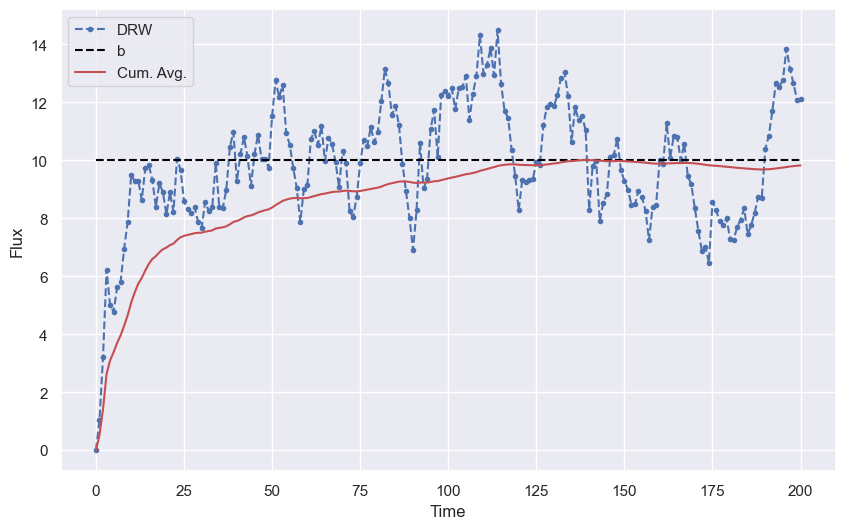

In [13]:
t = np.linspace(0, 200, 201) # time array
tau, sigma, b = 10, 1, 10
params = [tau, sigma, b] # tau, sigma, b
drw = drw_step(t, *params)

# plot
plt.figure(figsize=(10, 6))
plt.plot(t, drw, '.--', label=('DRW'))
plt.hlines(b, t[0], t[-1], colors='black', linestyles="dashed", label='b')
# cumulative average?
cumavg = np.cumsum(drw)/np.linspace(1, len(drw), len(drw))
plt.plot(t, cumavg, 'r', label='Cum. Avg.')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()
plt.show()

In their paper, Kelly et al. describe three different timescales relevant to quasars that they introduce as characteristic timescales and plot with. I'm going to do the same. These are equations (3), (4), and (5) in the paper, describing the light-crossing time, gas-orbiting time, and thermal time for the disk, respectively. I'm just going to be using standard values for quasars: $M_{BH} = 10^8\: M_\odot$, $R = 100\: R_S$, $\alpha=0.01$ for this.

In [14]:
import astropy.units as u
import astropy.constants as c

In [15]:
alpha = 0.01
M_BH = 1e8 * c.M_sun
R_S = lambda M_BH=M_BH: 2*c.G*M_BH/c.c**2
R = 100 * R_S()

t_lc = lambda M=M_BH, R=R: 1.1 * (M/(1e8*c.M_sun)) * (R/(100*R_S(M_BH))) * u.day
t_orb = lambda M=M_BH, R=R: 104 * (M/(1e8*c.M_sun)) * (R/(100*R_S(M_BH)))**(3/2) * u.day
t_th = lambda a=alpha, M=M_BH, R=R: 4.6 * (a/0.01)**-1 * (M/(1e8*c.M_sun)) * (R/(100*R_S(M_BH)))**(3/2) * u.yr

print(f't_lc: {t_lc()}, \nt_orb: {t_orb()}, \nt_th: {t_th().to(u.d):.2f}')

t_lc: 1.1 d, 
t_orb: 104.0 d, 
t_th: 1680.15 d


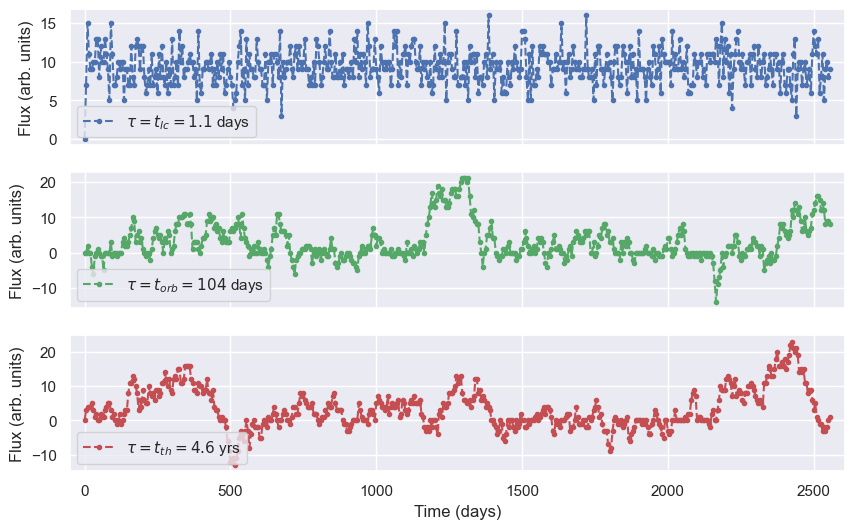

In [17]:
timesteps = np.arange(0, 7*365+1, 5)

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 6))
ax[0].plot(timesteps, drw_step(timesteps, t_lc().value, 1., 10.), 'b.--', label=(r'$\tau=t_{lc}=1.1$ days'))
ax[1].plot(timesteps, drw_step(timesteps, t_orb().value, 1., 10.), 'g.--', label=(r'$\tau=t_{orb}=104$ days'))
ax[2].plot(timesteps, drw_step(timesteps, t_th().to(u.d).value, 1., 10.), 'r.--', label=(r'$\tau=t_{th}=4.6$ yrs'))
[ax[_].legend(loc='lower left') for _ in range(len(ax))]
# fig.legend()
plt.xlabel('Time (days)')
plt.xlim(np.max(timesteps)-np.max(timesteps)*1.02, np.max(timesteps)*1.02)
[ax[_].set_ylabel('Flux (arb. units)') for _ in range(len(ax))]
plt.show()

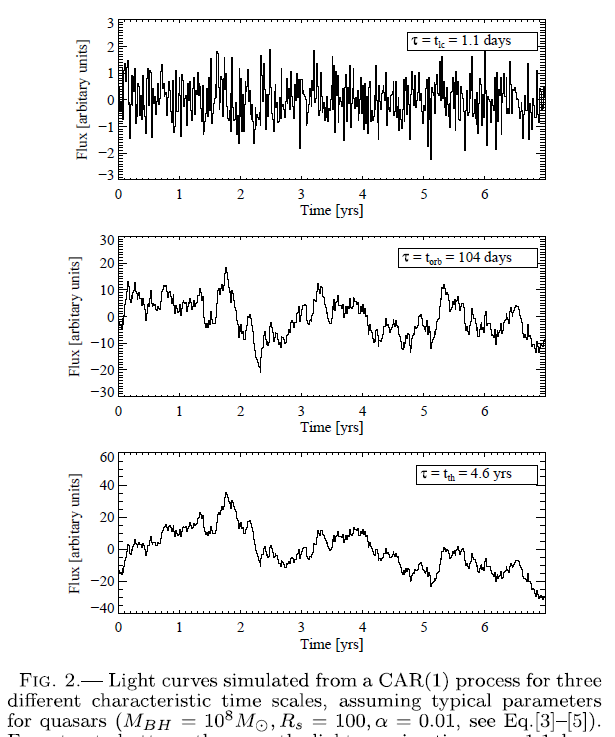

Above is from the Kelly et al. 2009 paper that I am mimicking. They write: *"The increased amount of variation on long time scales with increasing $\tau$ is apparent."* I do not get the same result, for some reason, using their equation (1). Changing the time to be an exponentially decaying term helps, but I'm not sure what the implications for the physics are, nor whether the variance term should be changed to suit.

---



## Generating synthetic data as the Javelin github uses.
Very much trying to replicate https://github.com/nye17/javelin. In the Zu et al. 2011 paper they say they are using a DRW from Kelly et al. 2009. Did that above, using their equation (1), modified so I got similar results as they did:
$\begin{equation}
    dX(t) = X(t)\exp{\left[{-\frac{1}{\tau}dt}\right]} + \sigma\sqrt{dt}\:\epsilon(t) + b\: \left(1-\exp{\left[{-\frac{1}{\tau}dt}\right]}\right)
\end{equation}$

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

In [142]:
# defining the step dX(t):
def gen_drw(t, tau, sigma, b, x0=0.):
    """Damped Random Walk Step
    Args:
        t (array): the time series
        tau (float): relaxation time / characteristic time scale, origin in characteristic timescales for quasars
        sigma (float): variance
        b (float): mean? unsure atm
        x0 (float): starting value
    
    Returns:
        x (array): Damped Random Walk
    """
    
    x = np.zeros_like(t)
    x[0] = x0
    dt = np.diff(t)
    for i in range(1, len(t)):
        exp_term = np.exp(- dt[i-1] / tau)
        x[i] = x[i-1] * exp_term + sigma * np.sqrt(dt[i-1]) * np.random.normal(0, 1) + b * (1 - exp_term)
    
    return x

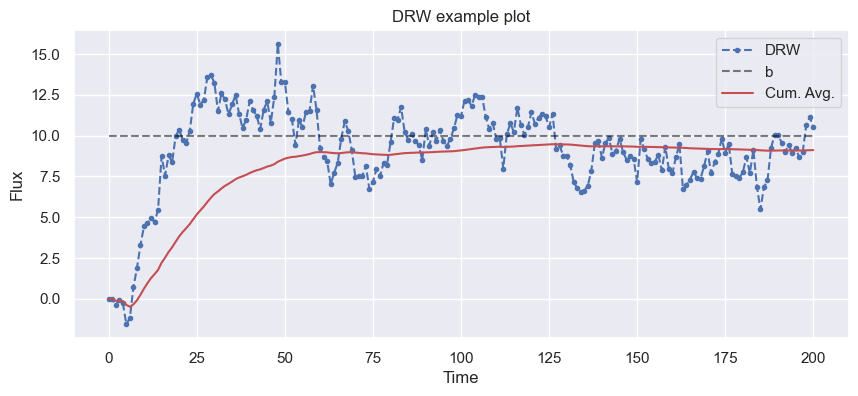

In [163]:
t = np.linspace(0, 200, 201)
tau, sigma, b = 10, 1, 10
params = [tau, sigma, b]
flux = gen_drw(t, *params)

# plot
plt.figure(figsize=(10, 4))
plt.plot(t, flux, '.--', label=('DRW'))
plt.hlines(b, t[0], t[-1], colors='black', linestyles="dashed", alpha=0.5, label='b')
# cumulative average?
cumavg = np.cumsum(flux)/np.linspace(1, len(flux), len(flux))
plt.plot(t, cumavg, 'r', label='Cum. Avg.')
plt.xlabel('Time'), plt.ylabel('Flux'), plt.title('DRW example plot')
plt.legend(), plt.show() ;

So that's our continuum. Now, to generate lagged line spectra. These needs three parameters: the lag t, the width of the tophat smoothing function w, and the flux scaling factor s.

In [144]:
''' Code from https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html '''

def smooth(x, window_len=11, window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(), s, mode='valid')
    return y

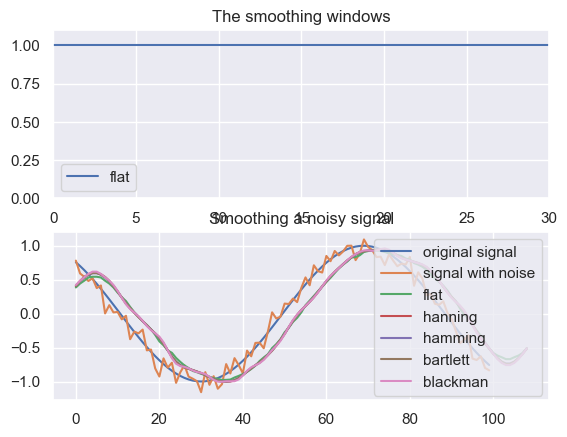

In [145]:
def smooth_demo():
    t=np.linspace(-4,4,100)
    x=np.sin(t)
    xn=x+np.random.randn(len(t))*0.1
    y=smooth(x)

    ws=31

    plt.subplot(211)
    plt.plot(np.ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    # plt.hold(True)
    # for w in windows[1:]:
    #     np.eval('plt.plot('+w+'(ws) )')

    plt.axis([0,30,0,1.1])

    plt.legend(windows)
    plt.title("The smoothing windows")
    plt.subplot(212)
    plt.plot(x)
    plt.plot(xn)
    for w in windows:
        plt.plot(smooth(xn,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    plt.legend(l)
    plt.title("Smoothing a noisy signal")
    plt.show()
smooth_demo()

In [146]:
def gen_lag(c_t, c_f, t, w, s):
    """Takes the time and flux arrays from a continuum and lags, smoothes, and scales them
    Args:
        c_t (array): continuum time array
        c_f (array): continuum flux array
        t (float): lag time
        w (float): smoothing width
        s (float): scale factor

    Returns:
        lag_t: lagged time
        lag_f: smoothed and scaled flux
    """
    
    lag_t = c_t + t
    tophat = np.ones(int(w))/w # tophat kernel for smoothing. convolve with signal to smooth
    lag_f = s*(convolve(c_f, tophat, mode='same'))
    return lag_t, lag_f

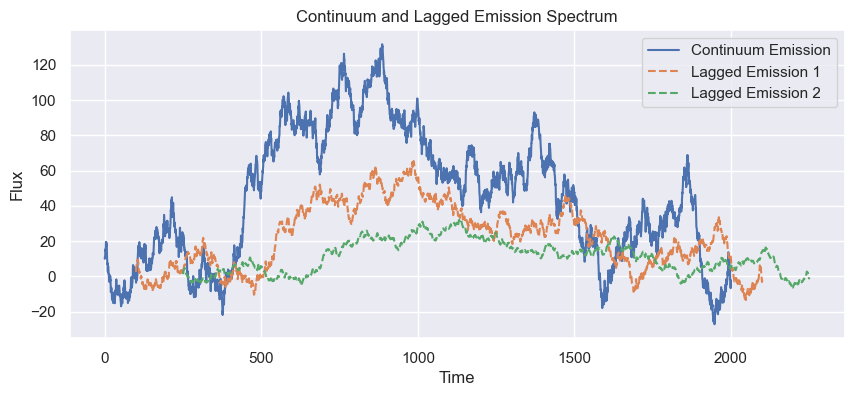

In [156]:
np.random.seed(42)  # For reproducibility
continuum_times = np.linspace(0, 2000, 4001)  # arbitrary n
continuum_flux = gen_drw(continuum_times, 400., 3., 10., 10.)  # using javelin's numbers

# Generate a lagged spectrum
p1 = 100, 2, 0.5 # Ylem numbers from javelin
p2 = 250, 4, 0.25 # Zing numbers from javelin
params = [p1, p2]

plt.figure(figsize=(10, 4))
plt.plot(continuum_times, continuum_flux, label='Continuum Emission')
for i, p in enumerate(params):
    lag, width, scale = p
    lagged_times, lagged_flux = gen_lag(continuum_times, continuum_flux, lag, width, scale)
    plt.plot(lagged_times, lagged_flux, label=f'Lagged Emission {i+1}', linestyle='--')
plt.xlabel('Time'), plt.ylabel('Flux'), plt.legend(), plt.title('Continuum and Lagged Emission Spectrum')
plt.show()

Obviously there is the problem of the data no longer "starting" at the same time. In reality, the continuum would be continuous in time and therefore the lagged signals would contain flux that originates earlier than the earliest point we can see in the continuum. Assuming they start simultaneously. Idk how javelin gets around this other than just cutting the arrays to look nice. It's not automated.

Smoothing is a little arcane to me and might not be exactly how they've done it in javelin.

Next is masking out seasonal gaps, adding noise and downsampling.

In [262]:
def downsample(times, flux, noise=1., downsample_rate=0.3, gap_gap=180, gap_length=90, lag=0):
    
    # downsample
    num = len(times)
    keep_indices = np.random.choice(num, int(downsample_rate * num), replace=False)
    keep_indices.sort()
    downsampled_times = times[keep_indices]
    downsampled_flux = flux[keep_indices]
    
    # apply seasonal mask
    mask = np.ones_like(downsampled_times, dtype=bool)
    for i in np.arange(downsampled_times[0], downsampled_times[-1], gap_gap):
        start = i
        length = i + gap_length
        mask &= (downsampled_times < start) | (downsampled_times >= length) # &= means "AND" bc mask is already all trues. now both mask and the conditions have to be true
                                                    # the conditions are "times before the start time" *or* "times after the start+duration time"
    gap_times = downsampled_times[mask]
    gap_flux = downsampled_flux[mask]
    
    # add noise to flux
    gap_flux += np.random.normal(0, noise, size=len(gap_flux))
    
    return gap_times, gap_flux

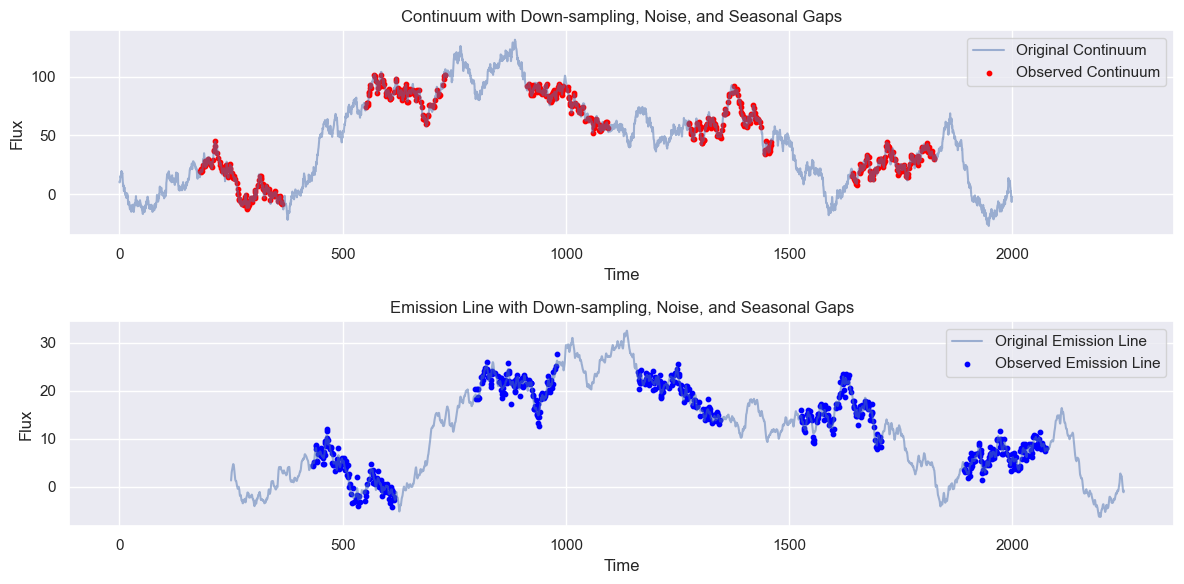

In [261]:
# generate new continuum and lagged line(s)
np.random.seed(42)  # For reproducibility
continuum_times = np.linspace(0, 2000, 4001)  # arbitrary n
continuum_flux = gen_drw(continuum_times, 400., 3., 10., 10.)
lag, width, scale = 250, 4, 0.25
lagged_times, lagged_flux = gen_lag(continuum_times, continuum_flux, lag, width, scale)

sim_c_times, sim_c_flux = downsample(continuum_times, continuum_flux)
sim_l_times, sim_l_flux = downsample(lagged_times, lagged_flux, lag=lag)

plt.figure(figsize=(12, 6))
ax = plt.subplot(2, 1, 1)
plt.plot(continuum_times, continuum_flux, label='Original Continuum', alpha=0.5)
plt.scatter(sim_c_times, sim_c_flux, color='red', label='Observed Continuum', s=10)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Continuum with Down-sampling, Noise, and Seasonal Gaps')
plt.legend()

plt.subplot(2, 1, 2, sharex=ax)
plt.plot(lagged_times, lagged_flux, label='Original Emission Line', alpha=0.5)
plt.scatter(sim_l_times, sim_l_flux, color='blue', label='Observed Emission Line', s=10)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Emission Line with Down-sampling, Noise, and Seasonal Gaps')
plt.legend()

plt.tight_layout()
plt.show()

The seasonal gaps need to line up, which they don't, and should probably also roll so that they start at 0, not at gap_length. i'm really tired.